# Get the cross-bispectra 

In [1]:
from scripts.imports import *
import scripts.lensing as lens

In [2]:
# Load cosmology from CAMB
pars = camb.read_ini('./planck_2018.ini')
results = camb.get_results(pars)

# get the radial comoving distance and redshift at recombination 
chi_cmb = results.conformal_time(0)- results.tau_maxvis # recombination
zcmb = results.redshift_at_comoving_radial_distance(chi_cmb)

# set other variables
kmax = 100 # maximum k for matter spectra
lmax = 2500 # maximum multipole for CMB spectra
ell_acc = 2 # 1 for all ells
ells = np.linspace(2,lmax, int((lmax-2)/ell_acc))

nz = 200 # sampling of redshift

The theoretical matter bispectrum is defined as
$$ B_\delta(k_1,k_2,k_3) = 2 F_2(k_1,k_2)P_\delta^{\mathrm{NL}}(k_1)P_\delta^{\mathrm{NL}}(k_2) + \mathrm{perms}$$
where $P_\delta^{\mathrm{NL}}$ is the nonlinear matter power spectrum and $F_2(k_i,k_j)$ is the so-called symmetrized two-point kernel (see https://arxiv.org/pdf/1111.4477.pdf as a reference). 

In [3]:
# Get the matter power spectra
# nonlinear delta power spectrum
Pdelta = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,k_per_logint=None,
    var1=model.Transfer_tot,var2=model.Transfer_tot, zmax=zcmb)

# linear delta power spectrum -> needed to compute k_NL and n_eff
Plin, Plin_z, Plin_k = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax,k_per_logint=None,
    var1=model.Transfer_tot,var2=model.Transfer_tot, zmax=zcmb, return_z_k=True)

Compute $k_{\mathrm{NL}}$, which is defined as the scale where the dimensionless matter power spectrum becomes 1
$$\frac{k^3}{2\pi^2}P_\delta^{\mathrm{Lin}}(k)\equiv 1$$

In [4]:
#Compute k_NL, from http://cmbant.github.io/notebooks/PostBorn.html
zmax_lss = 5.2 
zP = np.exp(np.linspace(0, np.log(zmax_lss+1),50))-1
kNLs = np.zeros(zP.shape)
for i,z in enumerate(zP):
    def f(k):
        return (k**3*Plin.P(z,k)/(2*np.pi**2)-1)**2
    kNL = optimize.golden(f, brack=[1e-4, kmax])
    kNLs[i]=kNL
kNLsp=spl(zP,kNLs, s=0)

/global/homes/a/akalaja/.local/lib/python3.7/site-packages/camb/results.py:953: RuntimeWarning: invalid value encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))


Compute $n_\mathrm{eff}$, defined as
$$n_\mathrm{eff} = \frac{d\log P_\delta^{\mathrm{Lin}}(k)}{d \log k}$$

In [5]:
#De-wiggled d ln P/dln k (simple dewiggling recipe) from http://cmbant.github.io/notebooks/PostBorn.html
neff_k=Plin(0.1,np.log(Plin_k),grid=False, dy=1) # this takes the derivative
w=np.ones(neff_k.size)
w[Plin_k<5e-3]=100
w[Plin_k>1]=10
n_eff = spl(np.log(Plin_k), neff_k, s=10, w =w) # interpolate (see fig. 1 of https://arxiv.org/pdf/1111.4477.pdf)

In [6]:
#get sigma_8(z)
pars.set_matter_power(redshifts = zP, kmax=kmax)
results = camb.get_results(pars)
s8vals=results.get_sigma8()[::-1]
s8 = spl(zP, s8vals,s=0)   

Note: redshifts have been re-sorted (earliest first)


Introduce functions needed to compute $F_2(k_i,k_j)$

In [7]:
def a(k,z,a1,a2,a6):
    q = k/kNLsp(z)
    n = n_eff(np.log(k))
    Q = (4-2**n)/(1+2**(n+1))
    nom = 1 + s8(z)**(a6) * (0.7*Q)**(1/2)*(q*a1)**(n+a2)
    denom = 1 + (q*a1)**(n+a2)
    res = nom/denom
    res[np.isnan(res)] = 1. # avoid problems
    return res

def b(k,z,a3,a7,a8):
    q = k/kNLsp(z)
    n = n_eff(np.log(k))#n_eff(z)
    Q = (4-2**n)/(1+2**(n+1))
    nom = 1 + 0.2*a3*(n+3)*(q*a7)**(n+3+a8)
    denom = 1 + (q*a7)**(n+3.5+a8)
    res = nom/denom
    res[np.isnan(res)] = 1.
    return res

def c(k,z,a4,a5,a9):
    q = k/kNLsp(z)
    n = n_eff(np.log(k))#n_eff(z)
    Q = (4-2**n)/(1+2**(n+1))
    nom = 1 + ((4.5*a4)/(1.5+(n+3)**4))*(q*a5)**(n+3+a9)
    denom = 1 + (q*a5)**(n+3.5+a9)
    res = nom/denom
    res[np.isnan(res)] = 1.
    return res

Let's compute the matter bispectrum, for now with the fitting formula provided by Gil-Marin (https://arxiv.org/pdf/1111.4477.pdf)

In [8]:
def matter_bispectrum(k1,k2,k3,z,interpk):
    
    a1 = 0.484
    a2 = 3.740
    a3 = -0.849
    a4 = 0.392
    a5 = 1.013
    a6 = -0.575
    a7 = 0.128
    a8 = -0.722
    a9 = -0.926
    
    # angles between k_i and k_j
    cos12 = (k3**2-k1**2-k2**2)/2/k1/k2
    cos23 = (k1**2-k2**2-k3**2)/2/k2/k3
    cos31 = (k2**2-k3**2-k1**2)/2/k3/k1

    
    pk1 = interpk.P(z,k1,grid = False)
    pk2 = interpk.P(z,k2,grid = False)
    pk3 = interpk.P(z,k3,grid = False)
    
    ak1 = a(k1,z,a1,a2,a6)
    ak2 = a(k2,z,a1,a2,a6)
    ak3 = a(k3,z,a1,a2,a6)
    
    bk1 = b(k1,z,a3,a7,a8)
    bk2 = b(k2,z,a3,a7,a8)
    bk3 = b(k3,z,a3,a7,a8)
    
    ck1 = c(k1,z,a4,a5,a9)
    ck2 = c(k2,z,a4,a5,a9)
    ck3 = c(k3,z,a4,a5,a9)
    
    F12 = 5/7 * ak1*ak2 + (k1**2+k2**2)/(2*k1*k2)*bk1*bk2*cos12 + 2/7 *ck1*ck2*cos12**2 
    F23 = 5/7 * ak2*ak3 + (k2**2+k3**2)/(2*k2*k3)*bk2*bk3*cos23 +  2/7 *ck2*ck3*cos23**2 
    F13 = 5/7 * ak1*ak3 + (k1**2+k3**2)/(2*k1*k3)*bk1*bk3*cos31 + 2/7 *ck1*ck3*cos31**2
  
    value = 2*F12*pk1*pk2 + 2*F23*pk2*pk3 + 2*F13*pk1*pk3
    return value

Cross-bispectra:
$$ B_{xyz}(\ell_1,\ell_2,\ell_3) = \left(\frac{3\Omega_{m,0} H_0^2}{2c^2}\right)^3\int_0^{\chi_*}\mathrm{d}\chi\, \chi^2 W_x(\chi)W_y(\chi)W_z(\chi) (1+z(\chi))B(k_1,k_2,k_3,z),$$
where $k_i = \ell_i/\chi$

In [9]:
Omega_m = (pars.ombh2+pars.omch2)/pars.h**2
H = pars.h*100
c_light = 2.99792458e5 #km/s

In [10]:
def lenbispec_xyz(ls,interpk,btype,exp=None,chi_cmb=None,chi_gamma=None):
    """
    --- btype: 'kkk', 'kss', 'kks','sss'
    """
    
    ls = ls.astype(np.float64)
    
    if btype=='kkk':
        chi_cmb = np.float64(chi_cmb)
        chis = np.linspace(0,chi_cmb,nz)
        zs = results.redshift_at_comoving_radial_distance(chis)
        chis = chis[1:-1]
        zs = zs[1:-1]
        win = (1-chis/chi_cmb)**3*chis**3
        
    if btype=='kss':
        chi_cmb = np.float64(chi_cmb)
        chi_gamma = np.float64(chi_gamma)
        chis = np.linspace(0,chi_gamma,nz)
        zs = results.redshift_at_comoving_radial_distance(chis)
        chis = chis[1:-1]
        zs = zs[1:-1]
        win1 = (1-chis/chi_cmb)*chis # check if chi_gamma is fine
        dndz_full, idndz_full, _ = lens.get_num_dens_gal(zs, exp)
    
        win2=np.zeros(zs.shape)
        for j in range(len(zs)):
            zint = np.linspace(zs[j],zs[-1],nz, dtype=np.float64)
            chiint = results.comoving_radial_distance(zint)
            chiint = chiint[1:-1]
            zint = zint[1:-1]
            dndz, _, _ = lens.get_num_dens_gal(zint, exp)
            window = dndz*(1-chis[j]/chiint)/idndz_full
            win2[j] = chis[j]*integrate.trapz(window, x=zint)
        win = win1*win2**2
    
    if btype=='kks':
        chi_cmb = np.float64(chi_cmb)
        chi_gamma = np.float64(chi_gamma)
        chis = np.linspace(0,chi_gamma,nz)
        zs = results.redshift_at_comoving_radial_distance(chis)
        chis = chis[1:-1]
        zs = zs[1:-1]
        win1 = (1-chis/chi_cmb)*chis
        dndz_full, idndz_full, _ = lens.get_num_dens_gal(zs, exp)
    
        win2=np.zeros(zs.shape)
        for j in range(len(zs)):
            zint = np.linspace(zs[j],zs[-1],nz, dtype=np.float64)
            chiint = results.comoving_radial_distance(zint)
            chiint = chiint[1:-1]
            zint = zint[1:-1]
            dndz, _, _ = lens.get_num_dens_gal(zint, exp)
            window = dndz*(1-chis[j]/chiint)/idndz_full
            win2[j] = chis[j]*integrate.trapz(window, x=zint)
        win = win1**2*win2
        
    if btype=='sss':
        chi_gamma = np.float64(chi_gamma)
        chis = np.linspace(0,chi_gamma,nz)
        zs = results.redshift_at_comoving_radial_distance(chis)
        chis = chis[1:-1]
        zs = zs[1:-1]
        dndz_full, idndz_full, _ = lens.get_num_dens_gal(zs, exp)
    
        win1=np.zeros(zs.shape)
        for j in range(len(zs)):
            zint = np.linspace(zs[j],zs[-1],nz, dtype=np.float64)
            chiint = results.comoving_radial_distance(zint)
            chiint = chiint[1:-1]
            zint = zint[1:-1]
            dndz, _, _ = lens.get_num_dens_gal(zint, exp)
            window = dndz*(1-chis[j]/chiint)/idndz_full
            win1[j] = chis[j]*integrate.trapz(window, x=zint)
        win = win1**3
        
    const = (3*Omega_m*H**2)*(1+zs)/(2*c_light**2)
    bisp=np.zeros(ls.shape[0])
    w = np.ones(chis.shape[0])
    # H_z = results.hubble_parameter(zs)
    for i, (l1,l2,l3) in enumerate(ls):
        k1=(l1+0.5)/chis
        k2=(l2+0.5)/chis
        k3=(l3+0.5)/chis
        B = matter_bispectrum(k1,k2,k3,zs,interpk)
        
        w[:]=1
        w[k1<1e-4]=0
        w[k1>=kmax]=0
        w[k2<1e-4]=0
        w[k2>=kmax]=0
        w[k3<1e-4]=0
        w[k3>=kmax]=0    
        
        bisp[i] = integrate.trapz(const**3*win*B/chis**4*w,x = chis)
 
    return bisp

In [11]:
lequil =np.zeros((ells.size,3))
for i,l in enumerate(ells):
    lequil[i,:]=l,l,l  

In [12]:
kkk_equil = lenbispec_xyz(lequil,Pdelta,'kkk',exp=None,chi_cmb=chi_cmb,chi_gamma=None)

/global/homes/a/akalaja/.conda/envs/albaenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


Cross-bispectra for a Euclid-type of redshift distribution of galaxies

In [13]:
z_eucl = np.linspace(0.0, 3., nz)
chi_eucl = results.comoving_radial_distance(z_eucl[-1])

In [14]:
kss_equil = lenbispec_xyz(lequil,Pdelta,'kss',exp='Euclid',chi_cmb=chi_cmb,chi_gamma=chi_eucl)

/global/cscratch1/sd/akalaja/cross_bispectra/scripts/lensing.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  K = tot_ngal/num_gal


In [15]:
kks_equil = lenbispec_xyz(lequil,Pdelta,'kks',exp='Euclid',chi_cmb=chi_cmb,chi_gamma=chi_eucl)

In [16]:
sss_equil = lenbispec_xyz(lequil,Pdelta,'sss',exp='Euclid',chi_cmb=None,chi_gamma=chi_eucl)

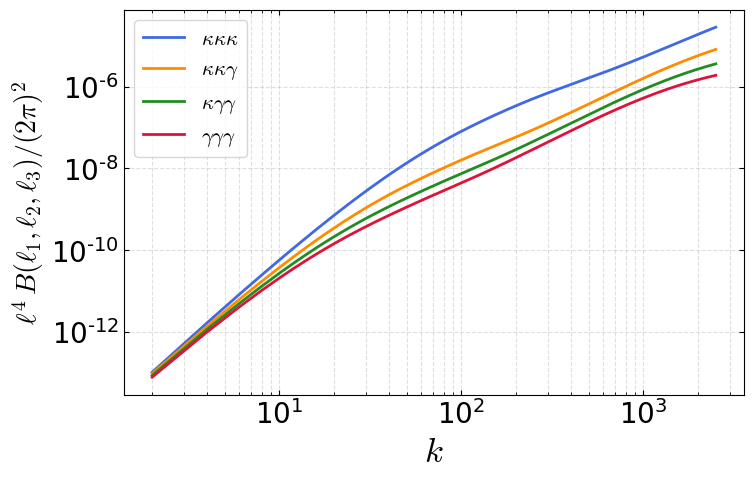

In [17]:
plt.figure(figsize=(8,5))
plt.loglog(ells, ells**4*kkk_equil/(2*np.pi)**2, label = r'$\kappa\kappa\kappa$', color = 'royalblue', linewidth = 2.0, zorder = 10)
plt.loglog(ells, ells**4*kks_equil/(2*np.pi)**2, label = r'$\kappa\kappa\gamma$', color = 'darkorange', linewidth = 2.0, zorder = 10)

plt.loglog(ells, ells**4*kss_equil/(2*np.pi)**2, label = r'$\kappa\gamma\gamma$', color = 'forestgreen', linewidth = 2.0, zorder = 10)
plt.loglog(ells, ells**4*sss_equil/(2*np.pi)**2, label = r'$\gamma\gamma\gamma$', color = 'crimson', linewidth = 2.0, zorder = 10)
# 
# plt.loglog(lnew,lnew**4*cmblensplus_equil/(2*np.pi)**2, label = r'cmblensplus', color = 'darkorange', linewidth = 2.0, zorder = 10)

plt.xlabel(r'$k$', fontsize=25)
plt.ylabel(r'$\ell^4\,B(\ell_1,\ell_2,\ell_3)/(2\pi)^2$', fontsize=20)
plt.legend(loc=0, fontsize = 15)
# plt.xlim([10,2e3])
# plt.ylim([1e-11,5e-4])

plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)
plt.show()